In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
#My modules
from decay_model.utility_functions import vae_functions_copy
from decay_model.models import Monopolar_VAE

#General modules
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import h5py
import numpy as np
np.set_printoptions(suppress=True)
import math
import matplotlib.pyplot as plt
from torch.utils import data
import os
from collections import namedtuple, defaultdict
import MEArec as mr
import spikeextractors as se
# sklearn import errors
import six
import sys
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
#
from decay_model.utility_functions import clustering_plotting_functions
from fastprogress import master_bar, progress_bar

print('torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

TrainSpike = namedtuple('DataPoint', ['amps', 'waveforms', 'ch_locs', 'center_loc', 'spike_id', 'exp_id',\
                                      'min_waveform', 'min_amp'])

import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 
mpl.rcParams.update({'font.size': 12})

torch: 1.10.1 cuda: False


In [21]:
parser = argparse.ArgumentParser(description='VAE Decay Model')
parser.add_argument('--batch-size', type=int, default=80, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=200, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 0)')
parser.add_argument('--log-interval', type=int, default=50, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--learning-rate', type=float, default=1e-3, metavar='N',
                    help='learning rate of ADAM')
parser.add_argument('--beta-one', type=float, default=0.99, metavar='N',
                    help='beta one ADAM')
parser.add_argument('--beta-two', type=float, default=0.999, metavar='N',
                    help='beta two ADAM')

args = parser.parse_args([])
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")
if(args.cuda):
    torch.cuda.set_device(0)

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

In [22]:
recording_directory = '/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/'
augmented_data_path = '/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/vae_mono/'
recording_name = 'recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13-31-005.h5'
width = 40
amp_jitter = 0

recgen = mr.load_recordings(recording_directory + recording_name)
channel_positions = recgen.channel_positions
soma_positions = np.asarray([st.annotations['soma_position'] for st in recgen.spiketrains])
SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)

hf_AO = h5py.File(str(augmented_data_path) + 'model_data_gt_'+ str(width) + 'um_VAE_'+str(amp_jitter)+'_amp_jitter_' + str(recording_name), 'r')
amp_array = np.asarray(hf_AO['amplitude'])
channel_loc_array = np.asarray(hf_AO['channel_locations'])
waveforms_array = np.asarray(hf_AO['waveforms'])
center_loc_array = np.asarray(hf_AO['center_locations'])
spike_time_list = np.asarray(hf_AO['spike_times'])
spike_id_list = np.asarray(hf_AO['spike_ids'])
hf_AO.close()

hf_label_AO = h5py.File(str(augmented_data_path) + 'label_data_gt_' + str(width) + 'um_VAE_'+str(amp_jitter)+'_amp_jitter_' + str(recording_name), 'r')
neuron_loc_array = np.asarray(hf_label_AO['neuron_locations'])
neuron_array = np.asarray(hf_label_AO['neurons'])
hf_label_AO.close()

In [23]:
#Random seeds
torch.manual_seed(0)
mid_frame = waveforms_array.shape[2]//2
cutout_start = 30
cutout_end = 30


#Augment the waveforms to indicate which come from real or virtual channels
waveforms_array = waveforms_array[:,:,mid_frame-cutout_start:mid_frame+cutout_start]
waveforms_array = np.concatenate((waveforms_array, amp_array[:,:,1].reshape(amp_array.shape[0], amp_array.shape[1], 1)),axis=2)

num_spikes = waveforms_array.shape[0]
num_amps = amp_array[0].shape[0]

torch_train_amps = torch.from_numpy(np.asarray(amp_array)).float()
torch_train_waveforms = torch.from_numpy(np.asarray(waveforms_array)).float()
torch_train_ch_locs = torch.from_numpy(np.asarray(channel_loc_array)).float()
exp_indices = torch.from_numpy(np.asarray(range(num_spikes)))

min_waveforms_list = []
for event_idx in range(amp_array.shape[0]):
    min_waveforms_list.append(waveforms_array[event_idx][np.argsort(amp_array[event_idx], 0)[:,0]][0][:-1])
min_waveforms_list = np.asarray(min_waveforms_list)

train_spikes = []
for i, amps in enumerate(torch_train_amps):
    waveforms = torch_train_waveforms[i]
    channel_locs = torch_train_ch_locs[i]
    center_loc = center_loc_array[i]
    exp_id = exp_indices[i]
    spike_id = spike_id_list[i]
    min_amp = np.min(min_waveforms_list[i])
    min_waveform = torch.from_numpy(min_waveforms_list[i]).float()
    train_spike = TrainSpike(amps=amps, waveforms=waveforms, ch_locs=channel_locs, center_loc=center_loc, spike_id=spike_id, exp_id=exp_id, \
                             min_waveform=min_waveform, min_amp=min_amp)
    train_spikes.append(train_spike)

training_set = vae_functions_copy.EventDataset(train_spikes)
train_loader = torch.utils.data.DataLoader(training_set, batch_size=args.batch_size, shuffle=True)

print("Training set: " + str(len(training_set)))
print("Waveform Input Size: " + str(training_set[0][1].shape))

Training set: 20718
Waveform Input Size: torch.Size([25, 61])


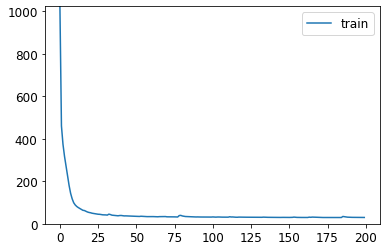

In [25]:
scalar = 2.0
abs_ = np.zeros((num_spikes, 2))
#Set exponential parameter initial values
for i, training_element in enumerate(training_set):
    init_peak = math.log(-(training_element[6].item()*scalar))
    abs_[i] = np.asarray([init_peak, -0.035])

model = Monopolar_VAE.Monopolar_VAE(training_set, args, abs_, optimize_both_exp=False, batchnorm=True, prior_var = 80, device = device)
model = model.to(device)
model.apply(Monopolar_VAE.weight_init)
optimizer = optim.Adam(list(model.parameters()) + [model.exps], lr=args.learning_rate, weight_decay=0,
                            betas=(args.beta_one, args.beta_two))

train_losses = []
n_epochs = args.epochs
mb = master_bar(range(20))
y_ax_index= 0 
for i in mb:
    epoch = i
    for j in progress_bar(range(int(n_epochs/20)), parent=mb):
        model = Monopolar_VAE.train(model, device, args, optimizer, train_loader, epoch, train_losses)
    x = range(len(train_losses))
    y = train_losses
    graphs = [[x,y]]
    y_bounds = [0,train_losses[0]]
    mb.update_graph(graphs, y_bounds=y_bounds)
    mb.write(f'Avg. Training Loss:  {train_losses[-1]}.')

In [32]:
eval_set = vae_functions_copy.EventDataset(training_set)
eval_loader = torch.utils.data.DataLoader(training_set, batch_size=args.batch_size, shuffle=False)
model.eval()
center_locs = []
vae_locs = []
spike_ids_list = []
for batch_idx, (t_amps, t_waveforms, t_ch_locs, center_loc, spike_ids, _, _, _) in enumerate(eval_loader):
    t_amps = t_amps.to(device) #torch.Size([200, 49, 2])
    t_waveforms = t_waveforms.to(device)
    x_mu, x_var, y_mu, y_var, z_mu, z_var = model.encode(t_amps, t_waveforms)
    vae_locs.append(np.asarray([x_mu.cpu().detach().numpy().squeeze(), y_mu.cpu().detach().numpy().squeeze() + center_loc[:,1].numpy(), z_mu.cpu().detach().numpy().squeeze() + center_loc[:,2].numpy()]))
    center_locs.append(np.asarray([center_loc[:,0].numpy(), center_loc[:,1].numpy(), center_loc[:,2].numpy()]))
    spike_ids_list.append(np.asarray(spike_ids))
vae_locs_all = np.concatenate(vae_locs, axis=1).T
center_locs_all = np.concatenate(center_locs, axis=1).T
spike_ids_array = np.concatenate(spike_ids_list, axis=0)

idx_sort = np.argsort(spike_ids_array)
sorted_spike_ids_array = spike_ids_array[idx_sort]
vals, idx_start, count = np.unique(sorted_spike_ids_array, return_counts=True,
                                return_index=True)
res = np.split(idx_sort, idx_start[1:])
#filter them with respect to their size, keeping only items occurring more than once
vals = vals[count >= 1]
res = filter(lambda x: x.size >= 1, res)
dup_spike_ids = []
for r in res:
    dup_spike_ids.append(r)
    
averaged_vae_locs = []
averaged_spike_times = []
averaged_min_waveforms = []
curr_index = 0
for spike_ids in dup_spike_ids:
    vae_loc = np.zeros(3)
    for spike_id in spike_ids:
        vae_loc[0] += vae_locs_all[curr_index][0]
        vae_loc[1] += vae_locs_all[curr_index][1]
        vae_loc[2] += vae_locs_all[curr_index][2]
        curr_index += 1
    vae_loc = vae_loc/len(spike_ids)
    averaged_vae_locs.append(vae_loc)
    averaged_spike_times.append(spike_time_list[spike_ids[0]])
    averaged_min_waveforms.append(min_waveforms_list[spike_ids[0]])
    
averaged_vae_locs = np.asarray(averaged_vae_locs)
averaged_spike_times = np.asarray(averaged_spike_times)
averaged_min_waveforms = np.asarray(averaged_min_waveforms)

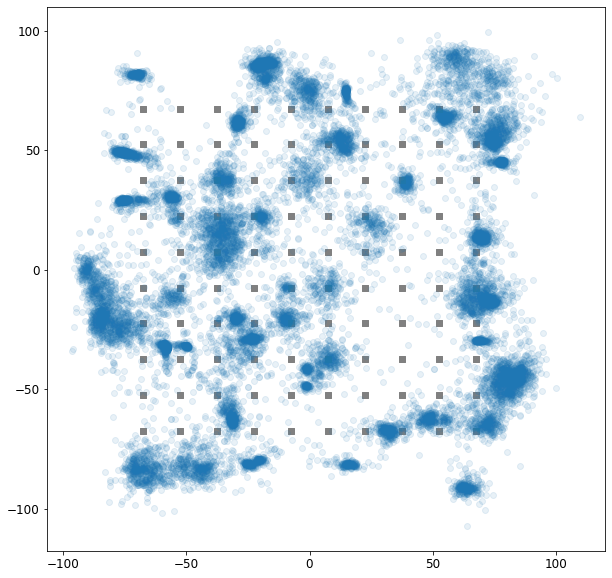

In [33]:
plt.figure(figsize=(10,10))
plt.scatter(channel_positions[:,1], channel_positions[:,2], marker='s', color='grey')
plt.scatter(averaged_vae_locs[:,1], averaged_vae_locs[:,2], alpha=.1)
#plt.scatter(vae_locs_all[:,1], vae_locs_all[:,2], alpha=.1)

In [34]:
training_set_array = np.asarray(training_set)
spike_ids_array = training_set_array[:,4]
idx_sort = np.argsort(spike_ids_array)
sorted_spike_ids_array = spike_ids_array[idx_sort]
#Here we are finding duplicate spikes that will have location estimates averaged (amp jitter)
vals, idx_start, count = np.unique(sorted_spike_ids_array, return_counts=True,
                                return_index=True)
res = np.split(idx_sort, idx_start[1:])
#filter them with respect to their size, keeping only items occurring more than once
vals = vals[count >= 1]
res = filter(lambda x: x.size >= 1, res)
dup_spike_ids = []
for r in res:
    dup_spike_ids.append(r)


var_threshold = float("inf")
training_set_array = np.asarray(training_set)

#all_vae_locs --> N x K where N is the number of neurons and K is the number of spikes for that neuron 
all_vae_locs, all_vae_variances, all_neuron_waveforms, all_spike_times = vae_functions_copy.getEstimatedLocationsGroundTruth(model, dup_spike_ids, neuron_loc_array, neuron_array, spike_time_list, device, \
                                                                                                                        training_set_array, amp_threshold=0)    

/Users/zelihasag/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order)
/Users/zelihasag/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

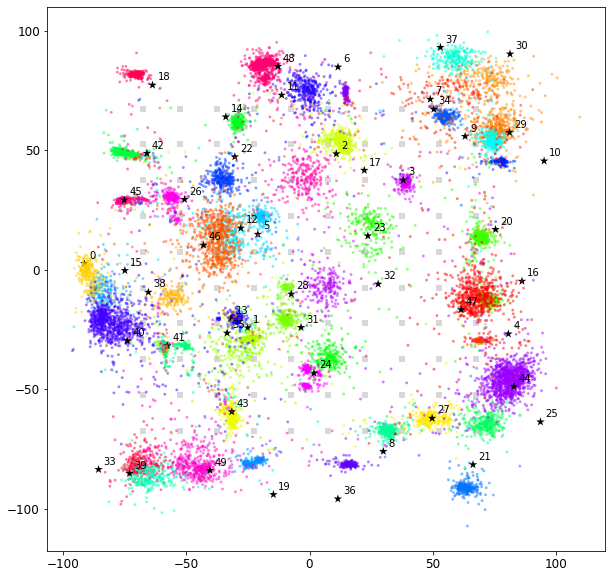

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
clustering_plotting_functions.plot2DLocations(channel_positions, range(50), all_vae_locs, soma_positions, dims=[1,2], alpha=.5, ax=ax, annotate=True);

In [36]:
save = True

waveform_size = waveforms_array.shape[2] - 1
save_path = "vae_mono/"
if(save):
    f = open(save_path + "loc_predictions_"+str(width) + "_" + str(amp_jitter) + "_amp_jit_wave_"+str(waveform_size)+".txt","w+")
    for neuron in range(50):
        for i, loc in enumerate(all_vae_locs[neuron]):
            est_loc_string = str(loc[0]) + "," + str(loc[1]) + "," + str(loc[2]) + ","
            spike_time = all_spike_times[neuron][i]
            waveform = all_neuron_waveforms[neuron][i].numpy()
            waveform_string = ",".join([str(reading) for reading in waveform]) + ","
            f.write(est_loc_string + waveform_string + str(spike_time) + ',' + str(neuron) + "\n")
    f.close()

    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'exps_0': model.exps_0,
                'exps': model.exps
                }, save_path + "model_state_dict_"+str(width) + "_" + str(amp_jitter) + "_amp_jit_wave_"+str(waveform_size)+".tar")

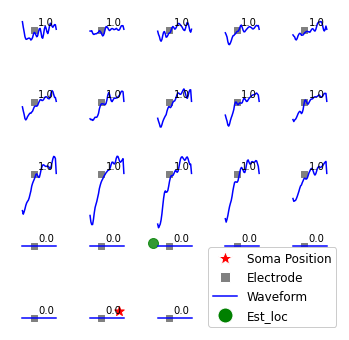

In [37]:
mid_frame = 50 # Middle frame of extracted waveform
cutout_start = 30 # Number of frames before peak to plot
cutout_end = 40 # Number of frames after peak to plot
neuron_id = 36 #Neuron ID for the example augmented data to be plotted

neuron_inds = []
for neuron in range(len(recgen.spiketrains)):
    neuron_inds.append(np.where(np.asarray(neuron_array)==neuron)[0][0])

event_id = neuron_inds[neuron_id]
amps = amp_array[event_id]
waveforms_plot = np.asarray(waveforms_array[event_id])[:,mid_frame-cutout_start:mid_frame+cutout_end]
channel_locs = channel_loc_array[event_id]
neuron_loc = neuron_loc_array[event_id]
neuron = neuron_array[event_id]
center_loc = center_loc_array[event_id]
estimated_locations = averaged_vae_locs[event_id]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for i in range(len(amps)):
    ax.scatter(channel_locs[i][1] + center_loc[1], channel_locs[i][2] + center_loc[2], s=30, c="grey", marker='s')
    readings = waveforms_plot[i]
    xs = np.linspace(-2.5, 5, waveforms_plot[i].shape[0])
    scaler = .1
    plt.plot(channel_locs[i][1] +  center_loc[1] + xs, channel_locs[i][2] + center_loc[2] + readings*.1, color='blue')
    observed = amps[i][1]
    text = ax.annotate(amps[i][1], (channel_locs[i][1] + center_loc[1] + 1, channel_locs[i][2] + center_loc[2] + 1))
    text.set_fontsize(10)
ax.scatter(neuron_loc[1] + center_loc[1], neuron_loc[2] + center_loc[2], s=100, marker='*', c="red")
ax.scatter(estimated_locations[1], estimated_locations[2], s=100, marker='o', c="green", alpha= 0.8)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False); # labels along the bottom edge are off

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,
    left=False,# ticks along the top edge are off
    labelbottom=False,
    labelleft=False); # labels along the bottom edge are off

from matplotlib.lines import Line2D
ax.set_axis_off()
line1 = Line2D(range(1), range(1), color="white", marker='*', markerfacecolor="red", markersize=15)
line2 = Line2D(range(1), range(1), color="white", marker='s', markerfacecolor="grey", markersize=10)
line3 = Line2D(range(1), range(1), color="blue", markerfacecolor="blue", markersize=12)
line4 = Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="green", markersize=15)

plt.legend((line1,line2,line3,line4),('Soma Position','Electrode', 'Waveform', 'Est_loc'), numpoints=1, loc=4, framealpha=1);


